In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [2]:
file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
diagType1 = 'ocean_cobalt_omip_sfc'
diagType2 = 'ocean_cobalt_omip_2d'

years = ['0481-0485', '0486-0490', '0491-0495', '0496-0500']
yearmons = ['048101-048512', '048601-049012', '049101-049512', '049601-050012']

In [3]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
chl_var = 'chlos'
chl_file_prefix = os.path.join(file_path, diagType1, 'ts', 'monthly', '5yr/')
chl_files = [dot.join([chl_file_prefix + diagType1, ym, chl_var, 'nc']) for ym in yearmons]
print(chl_files)

npp_var = 'intpp'
npp_file_prefix = os.path.join(file_path, diagType2, 'ts', 'annual', '5yr/')
npp_files = [dot.join([npp_file_prefix + diagType2, yy, npp_var, 'nc']) for yy in years]
print(npp_files)

['/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_cobalt_omip_sfc/ts/monthly/5yr/ocean_cobalt_omip_sfc.048101-048512.chlos.nc', '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_cobalt_omip_sfc/ts/monthly/5yr/ocean_cobalt_omip_sfc.048601-049012.chlos.nc', '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_cobalt_omip_sfc/ts/monthly/5yr/ocean_cobalt_omip_sfc.049101-049512.chlos.nc', '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_cobalt_omip_sfc/ts/monthly/5yr/ocean_cobalt_omip_sfc.049601-050012.chlos.nc']
['/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.n

In [5]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

### Models

In [6]:
#chl, create monthly climatology
ds_chl = xr.open_mfdataset(chl_files, combine='by_coords')
ds_chl = ds_chl.groupby('time.month').mean(dim='time')
ds_chl['chlos'].values = ds_chl['chlos'].values * 1e6 # unit conversion from kg chl m-3 to mg chl m-3


#npp
ds_npp = xr.open_mfdataset(npp_files, combine='by_coords')
ds_npp = ds_npp.mean(dim='time')
ds_npp['intpp'].values = ds_npp['intpp'].values * 12 * 1e3 * 86400 # unit conversion from mol C m-2 s-1 to mg C m-2 d-1
ds_npp['intpp'].attrs['units'] = 'mg C m-2 d-1'

### Observations

In [7]:
# Chl
chl_obs_file = '/work/jyl/validation_data/SO_Blended_Chl/globcolour_soblend_mc_esm4grid.nc'
chl_obs = xr.open_dataset(chl_obs_file)
chl_obs_ann = chl_obs.mean(dim='time')

# NPP - Carr
npp_carr_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/npp_carr_cas_mc_esm4grid.nc'
npp_carr = xr.open_dataset(npp_carr_file)
npp_carr = npp_carr.fillna(0).mean(dim='time')

# NPP - VGPM
npp_vgpm_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/npp_vgpm_cas_mc_esm4grid.nc'
npp_vgpm = xr.open_dataset(npp_vgpm_file)
npp_vgpm = npp_vgpm.fillna(0).mean(dim='time')

# NPP - VGPM-Eppley
npp_eppley_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/npp_eppley_cas_mc_esm4grid.nc'
npp_eppley = xr.open_dataset(npp_eppley_file)
npp_eppley = npp_eppley.fillna(0).mean(dim='time')


In [8]:
npp_obs = (npp_carr.npp_carr_mc + npp_vgpm.npp_vgpm_mc + npp_eppley.npp_eppley_mc) / 3.0
npp_obs = npp_obs.where(npp_obs != 0.) # areas where NPP values were zero are now NAs

# Evaluate Skill Metrics

In [9]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [10]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [11]:
# Annual means, Chlorophyll
X=ds_chl.chlos.mean(dim='month').stack(z=('xh','yh')).values
Y=chl_obs.chl.mean(dim='time').stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_chl = X[mask] - Y[mask]
res2_chl = np.log10(X[mask])-np.log10(Y[mask])
skew1_chl = stats.skew(res1_chl)
skew2_chl = stats.skew(res2_chl)
res_chl = res2_chl
r_chl = stats.pearsonr(np.log10(X[mask]),np.log10(Y[mask]))[0]
rmse_chl = rmse_diffs(res_chl)
bias_chl = np.mean(res_chl)

In [12]:
print(r_chl, rmse_chl, bias_chl)

0.6359900369256384 0.4066259437392275 0.11842380278321148


In [13]:
# Annual means, NPP
X=ds_npp.intpp.stack(z=('xh','yh')).values
Y=npp_obs.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_npp = X[mask] - Y[mask]
res2_npp = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_npp = stats.skew(res1_npp)
skew2_npp = stats.skew(res2_npp)
res_npp = res1_npp
r_npp = stats.pearsonr(X[mask],Y[mask])[0]
rmse_npp = rmse_diffs(res_npp)
bias_npp = np.mean(res_npp)

# Plot

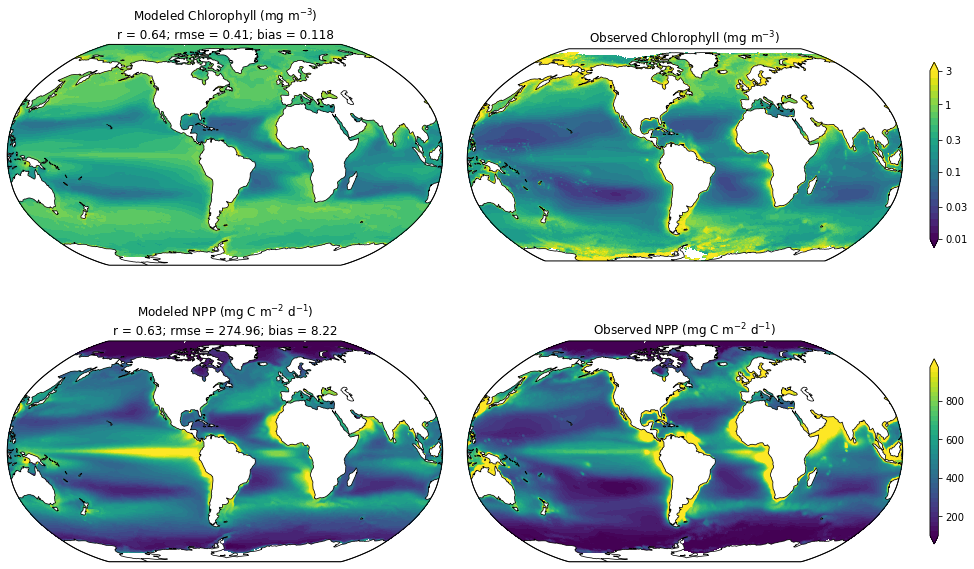

In [16]:
fig=plt.figure(figsize=(18,10))
gs=gridspec.GridSpec(2,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# chlorophyll                                                             #
###########################################################################
cmin = -2; cmax = 0.4772; cint = 0.1
levels=np.append(np.arange(cmin,cmax,cint),cmax)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(ds_chl.chlos.mean(dim='month'))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Chlorophyll (mg m$^{-3}$)\nr = ' + str(np.round(r_chl,2)) + \
                 '; rmse = ' + str(np.round(rmse_chl,2)) + \
                 '; bias = ' + str(np.round(bias_chl,3)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(chl_obs.chl.mean(dim='time'))
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Chlorophyll (mg m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([0.01, 0.03, 0.1, 0.3, 1, 3]), shrink=0.75)
cbar.ax.set_yticklabels([0.01, 0.03, 0.1, 0.3, 1, 3])

###########################################################################
# npp                                                                     #
###########################################################################
cmin=100; cmax=1000; cint=25
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_npp.intpp
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled NPP (mg C m$^{-2}$ d$^{-1}$)\nr = ' + str(np.round(r_npp,2)) + \
                 '; rmse = ' + str(np.round(rmse_npp,2)) + \
                 '; bias = ' + str(np.round(bias_npp,2)), fontsize=fs)

i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field=npp_obs
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed NPP (mg C m$^{-2}$ d$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[200,400,600,800,1000], shrink=0.75)

plt.tight_layout()
fname = 'Chl_NPPvSat'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')